In [1]:
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append("/mnt/datadisk/lizhongzhan/SpaMultiOmics/main/")
import scanpy as sc
import pandas as pd
import numpy as np
import os
import networkx as nx
from switch import SWITCH, preprocess
from itertools import chain

In [2]:
os.chdir("../../../DATA/H3k27ac/")

Preprocess

In [3]:
# rna = sc.read_h5ad("rna.h5ad")
# atac = sc.read_h5ad("atac.h5ad")
# (rna.obs_names==atac.obs_names).all()

In [4]:
# preprocess.get_gene_annotation(rna, 
#                     gtf="../../DATA/Mouse_embryo/gencode.vM25.annotation.gtf.gz",
#                     gtf_by="gene_name",
#                     drop_na=True
# )

In [5]:
# rna.layers["counts"] = rna.X.copy()
# sc.pp.highly_variable_genes(rna, n_top_genes=3000, flavor="seurat_v3", layer="counts")

In [6]:
# split = atac.var_names.str.split(r"[:-]")
# atac.var["chrom"] = split.map(lambda x: x[0])
# atac.var["chromStart"] = split.map(lambda x: x[1]).astype(int)
# atac.var["chromEnd"] = split.map(lambda x: x[2]).astype(int)
# ## print(i.var)

In [7]:
# print(atac.shape[1])
# sc.pp.filter_genes(atac, min_cells=atac.shape[0]*0.01)
# print(atac.shape[1])

In [8]:
# guidance = preprocess.rna_anchored_guidance_graph(rna, atac)
# len(atac.var[atac.var["highly_variable"]==True])

In [9]:
# guidance_hvf = guidance.subgraph(chain(
#    rna.var.query("highly_variable").index,
#    atac.var.query("highly_variable").index
# )).copy()
# nx.write_graphml(guidance_hvf, "guidance_hvf.graphml.gz")

In [10]:
# rna.write("rna-pp.h5ad")
# atac.write("atac-pp.h5ad")

In [11]:
rna = sc.read_h5ad("rna-pp.h5ad")
atac = sc.read_h5ad("atac-pp.h5ad")
guidance_hvf = nx.read_graphml("guidance_hvf.graphml.gz")

Training

In [12]:
preprocess.config_data(
    rna, "NB",
    use_highly_variable=True,
    use_layer="counts",
)
preprocess.config_data(
    atac, "POIS",
    use_highly_variable=True, 
)

In [13]:
preprocess.Cal_Spatial_Net(rna, rad_cutoff=55, model="Radius")
preprocess.Cal_Spatial_Net(atac, rad_cutoff=55, model="Radius")

- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.
- INFO - Calculating 'spatial' graph.
The graph contains 105214 edges, 9365 spots.
11.2348 neighbors per spot on average.


In [14]:
model = SWITCH(adatas={"rna": rna, "atac": atac}, vertices=sorted(guidance_hvf.nodes), h_depth_dsc=2)

- INFO - Set random seed to 0
- DEBUG - Use raw feature for the 'rna' dataset.
- DEBUG - Set 1 GAT conv layer for 'rna' dataset.
- DEBUG - Use NB distribution for the 'rna' dataset.
- DEBUG - Use raw feature for the 'atac' dataset.
- DEBUG - Set 1 GAT conv layer for 'atac' dataset.
- DEBUG - Use POIS distribution for the 'atac' dataset.
- DEBUG - Set 2 layers for the discriminator
- DEBUG - Use log normalize for the 'rna' dataset.
- DEBUG - Use log normalize for the 'atac' dataset.
- INFO - GPU available: True, used device: GPU 1


In [15]:
model.compile()

In [16]:
model.pretrain(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, 
             max_epochs=2000, dsc_k=4, early_stop=False, warmup=True)

- INFO - Prepare data for training.
- DEBUG - Set `dsc_k` = 4 for pretrain.
- DEBUG - Set `max_epochs` = 2000 for pretrain.
- INFO - Pretraining with full batch.
- INFO - Epoch 1 : dsc_loss=0.522, gen_loss=0.474
- INFO - Epoch 2 : dsc_loss=0.408, gen_loss=0.437
- INFO - Epoch 3 : dsc_loss=0.396, gen_loss=0.421
- INFO - Epoch 4 : dsc_loss=0.623, gen_loss=0.4
- INFO - Epoch 5 : dsc_loss=0.685, gen_loss=0.39
- INFO - Epoch 6 : dsc_loss=0.687, gen_loss=0.385
- INFO - Epoch 7 : dsc_loss=0.689, gen_loss=0.379
- INFO - Epoch 8 : dsc_loss=0.473, gen_loss=0.382
- INFO - Epoch 9 : dsc_loss=0.687, gen_loss=0.373
- INFO - Epoch 10 : dsc_loss=0.69, gen_loss=0.372
- INFO - Epoch 11 : dsc_loss=0.687, gen_loss=0.37
- INFO - Epoch 12 : dsc_loss=0.69, gen_loss=0.369
- INFO - Epoch 13 : dsc_loss=0.687, gen_loss=0.368
- INFO - Epoch 14 : dsc_loss=0.678, gen_loss=0.368
- INFO - Epoch 15 : dsc_loss=0.691, gen_loss=0.366
- INFO - Epoch 16 : dsc_loss=0.69, gen_loss=0.365
- INFO - Epoch 17 : dsc_loss=0.69, gen

In [17]:
model.train(adatas={"rna": rna, "atac": atac}, graph=guidance_hvf, max_epochs=1000, dsc_k=8,
            warmup=True, warmup_kwargs={"step":50, "gamma":0.75})

- DEBUG - Set `dsc_k` = 8 for training.
- DEBUG - Set `max_epochs` = 1000 for training.
- INFO - Training with full batch.
- INFO - Epoch 1 : dsc_loss=0.66, gen_loss=0.818, cycle_loss=0.373, align_loss=0.79
- INFO - Epoch 2 : dsc_loss=0.7, gen_loss=0.813, cycle_loss=0.372, align_loss=0.777
- INFO - Epoch 3 : dsc_loss=0.689, gen_loss=0.81, cycle_loss=0.371, align_loss=0.761
- INFO - Epoch 4 : dsc_loss=0.69, gen_loss=0.808, cycle_loss=0.37, align_loss=0.755
- INFO - Epoch 5 : dsc_loss=0.691, gen_loss=0.807, cycle_loss=0.37, align_loss=0.753
- INFO - Epoch 6 : dsc_loss=0.692, gen_loss=0.806, cycle_loss=0.37, align_loss=0.752
- INFO - Epoch 7 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.751
- INFO - Epoch 8 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.751
- INFO - Epoch 9 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.37, align_loss=0.751
- INFO - Epoch 10 : dsc_loss=0.693, gen_loss=0.806, cycle_loss=0.369, align_loss=0.751
- INFO - Model training done

In [18]:
rna.obsm["SWITCH"] = model.encode_data("rna",rna)
atac.obsm["SWITCH"] = model.encode_data("atac",atac)

In [63]:
combined = sc.concat([rna, atac], label="omics")
sc.pp.neighbors(combined, use_rep="SWITCH", metric="cosine")
sc.tl.umap(combined, min_dist=0.3)

In [64]:
sc.tl.leiden(adata=combined, resolution=.9, key_added="leiden")
print(len(set(combined.obs["leiden"])))

20


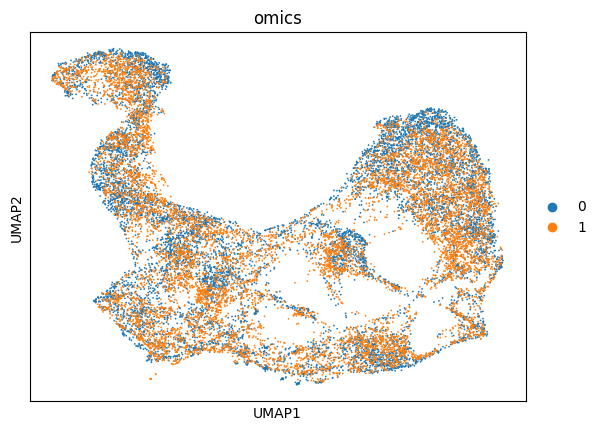

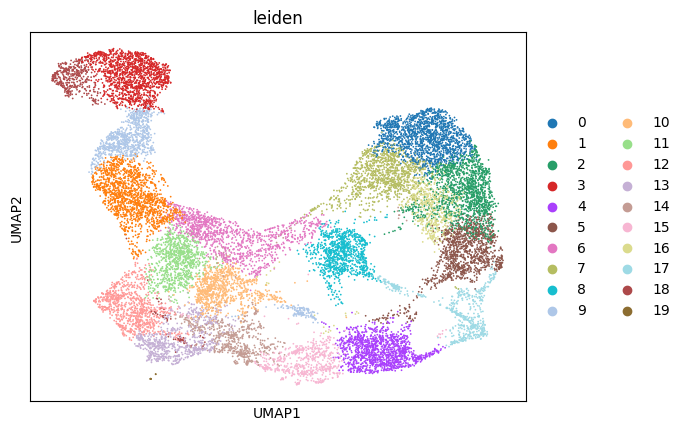

In [65]:
sc.pl.umap(combined, color="omics")
sc.pl.umap(combined, color="leiden")

In [66]:
t_rna = combined[combined.obs["omics"]=="0",]
t_atac = combined[combined.obs["omics"]=="1",]

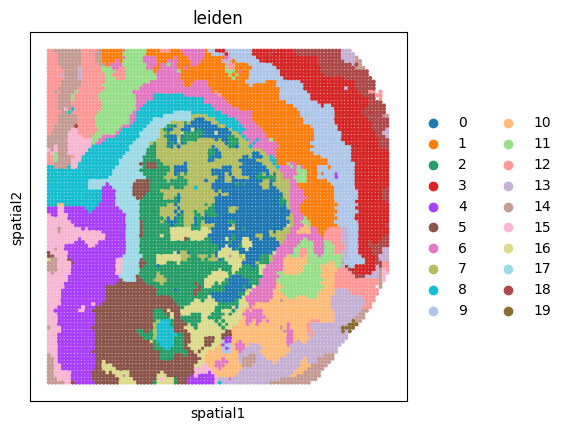

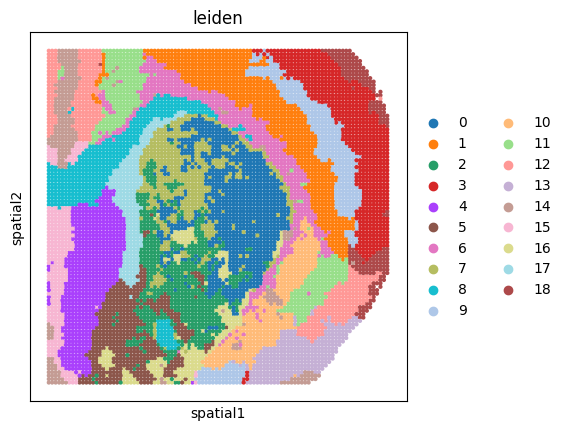

In [67]:
sc.pl.spatial(t_atac, color="leiden",spot_size=34)
sc.pl.spatial(t_rna, color="leiden",spot_size=34)

In [68]:
import scipy
def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
):
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    n1, _ = d.shape
    true_matching = np.arange(n1)
    mask = (d.T < d[np.arange(n1), true_matching]).T
    return np.mean(np.mean(mask, axis=1))
x=foscttm(t_rna.obsm["SWITCH"], t_atac.obsm["SWITCH"])
x

0.03586645759035657

In [69]:
# embed = pd.DataFrame(combined.obsm["SWITCH"])
# embed.to_csv("rep1/SWITCH_embed.csv")
# umap = pd.DataFrame(combined.obsm["X_umap"])
# umap.to_csv("rep1/SWITCH_umap.csv")
# cluster = pd.DataFrame(combined.obs["leiden"])
# cluster.to_csv("rep1/SWITCH_cluster.csv")